### Import Libraries

In [52]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

### Load the Data

In [53]:
df = pd.read_csv("Bengaluru_House_Data.csv")
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [54]:
df.shape

(13320, 9)

### Data Pre-processing 

#### Handling Missing Values

We see that there **41%** of values in the column **society** are missing. We can handle this situation by removing this column since its a categorical value. 

In [55]:
round((df.isnull().sum()/df.shape[0])*100)

area_type        0.0
availability     0.0
location         0.0
size             0.0
society         41.0
total_sqft       0.0
bath             1.0
balcony          5.0
price            0.0
dtype: float64

In [56]:
#Drop unecessary columns
df1 = df.drop(['society', 'availability', 'area_type', 'balcony'], axis = 1)

In [57]:
df1.shape

(13320, 5)

In [58]:
#Drop rows with missing values
df2 = df1.dropna()
df2.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [59]:
df2.shape

(13246, 5)

#### Handling Inconsistent Data

While exploring the **total_sqft** column we find out that the data in the column in inconsistent, some rows have a number while other rows have a range. 

To handle this, we write a function to convert the range into mean value of the range.

In [60]:
df2['total_sqft'].unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

In [61]:
def convert_total_sqft(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0])+float(tokens[1]))/2
    
    try:
        return float(x)
    except:
        return None

In [62]:
df3 = df2.copy()
df3['total_sqft']= df2['total_sqft'].apply(convert_total_sqft)
df3 = df3[df3.total_sqft.notnull()]
df3.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00
2,Uttarahalli,3 BHK,1440.0,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00
4,Kothanur,2 BHK,1200.0,2.0,51.00


In [63]:
df3['total_sqft'].unique()

array([1056. , 2600. , 1440. , ..., 1258.5,  774. , 4689. ])

#### Feature Engineering

While exploring the **size** column we notice there are inconsistencies in this column as well. Some values have *Bedroom* written while others have *BHK*.

To handle this, we create a new column named **BHK** and store only the numeric value present in the size column. 

In [64]:
df3['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

In [65]:
df4 = df3.copy()
df4['BHK'] = df3['size'].str.split(' ').str[0].astype('int')
df4.head()

,location,size,total_sqft,bath,price,BHK
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2


To make data exploration easier, we create a new column called price_per_sqft.

In [66]:
df5 = df4.copy()
df5['price_per_sqft'] = df5['price']*100000/df5['total_sqft']
df5.head()

,location,size,total_sqft,bath,price,BHK,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


#### Dimensionality Reduction

We see that there are **1298** unique values for the column location. This will give us trouble while one hot encoding. So we try to reduce the number of values. 

We notice that there are **1058** locations that have less than 10 rows. Those rows can be labelled as other in the location column. In that way we'll have only **241** unique value which is far less than **1298**. 

In [67]:
len(df5['location'].unique())

1298

In [68]:
location_row_count = df5.location.value_counts()
location_row_count.head()

Whitefield         532
Sarjapur  Road     392
Electronic City    302
Kanakpura Road     264
Thanisandra        232
Name: location, dtype: int64

In [69]:
location_rows_less_than_10 = location_row_count[location_row_count<=10]
len(location_rows_less_than_10)

1058

In [70]:
df5.location = df5.location.apply(lambda x: 'other' if x in location_rows_less_than_10 else x)
len(df5.location.unique())

241

In [71]:
df5.head(10)

,location,size,total_sqft,bath,price,BHK,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000
5,Whitefield,2 BHK,1170.0,2.0,38.00,2,3247.863248
6,Old Airport Road,4 BHK,2732.0,4.0,204.00,4,7467.057101
7,Rajaji Nagar,4 BHK,3300.0,4.0,600.00,4,18181.818182
8,Marathahalli,3 BHK,1310.0,3.0,63.25,3,4828.244275
9,other,6 Bedroom,1020.0,6.0,370.00,6,36274.509804


In [72]:
df5.shape

(13200, 7)

#### Outliers Detection 

Generally one bedroom is atleast 300 sqft. So we assume that houses with bedrooms less than 300 sqft are outliers. 

In [73]:
df5[df5.total_sqft/df5.BHK<300].head()

,location,size,total_sqft,bath,price,BHK,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,other,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,other,3 Bedroom,500.0,3.0,100.0,3,20000.000000


In [74]:
df6 = df5[~(df5.total_sqft/df5.BHK<300)]

In [75]:
df6.shape

(12456, 7)

We explore the **price_per_sqft** column and notice that the *min* and *max* values are very extreme. So, there is a possibility that they are outliers.

To handle this, we remove rows with price_per_sqft that are beyond 1 standard deviation, grouping by location. 

In [76]:
df6.price_per_sqft.describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

In [77]:
def remove_outliers(df):
    result = pd.DataFrame()
    for location, df_by_loc in df.groupby('location'):
        m = np.mean(df_by_loc.price_per_sqft)
        st = np.std(df_by_loc.price_per_sqft)
        new_df = df_by_loc[(df_by_loc.price_per_sqft>(m-st)) & (df_by_loc.price_per_sqft<=(m+st))]
        result = pd.concat([result,new_df],ignore_index=True)
    return result

df7 = remove_outliers(df6)
df7.shape

(10245, 7)

We visulaize the price and total_area columns and notice that there are some houses with 2 BHK that cost more than 3 BHK. These are considered to be outliers.

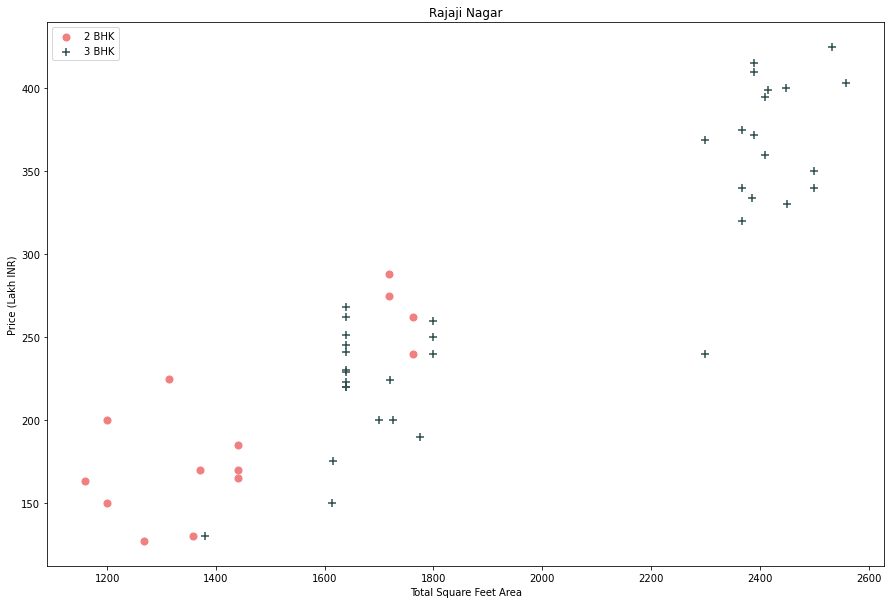

In [78]:
def plot_scatter_chart(df,location):
    bhk2 = df[(df.location==location) & (df.BHK==2)]
    bhk3 = df[(df.location==location) & (df.BHK==3)]
    plt.figure(figsize=(15, 10))
    plt.scatter(bhk2.total_sqft,bhk2.price,color='lightcoral',label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft,bhk3.price,marker='+', color='darkslategray',label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (Lakh INR)")
    plt.title(location)
    plt.legend()
    
plot_scatter_chart(df7,"Rajaji Nagar")

In [79]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('BHK'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('BHK'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')

df8 = remove_bhk_outliers(df7)
df8.shape

(7331, 7)

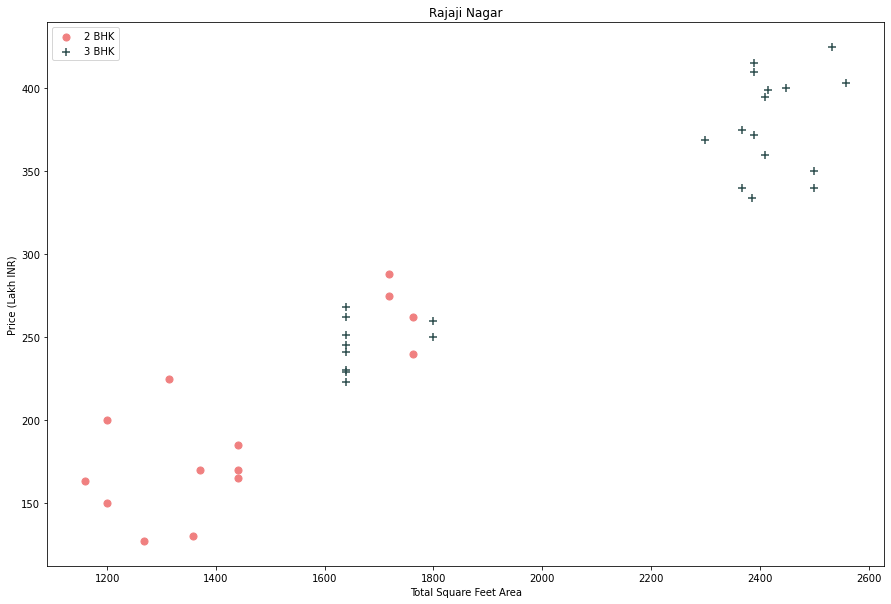

In [80]:
plot_scatter_chart(df8,"Rajaji Nagar")

When exploring the **bath** column, we notice that there are some houses where number of baths is a lot more than the number of bedrooms, which is pretty unusual. Here, we consider them as outliers. 

In [81]:
df8.bath.unique()

array([ 2.,  3.,  4.,  5.,  8.,  1.,  6.,  7.,  9., 12., 16., 13.])

In [82]:
df8[df8.bath > df8.BHK+2]

,location,size,total_sqft,bath,price,BHK,price_per_sqft
1637,Chikkabanavar,4 Bedroom,2460.0,7.0,80.0,4,3252.032520
5232,Nagasandra,4 Bedroom,7000.0,8.0,450.0,4,6428.571429
6702,Thanisandra,3 BHK,1806.0,6.0,116.0,3,6423.034330
8402,other,6 BHK,11338.0,9.0,1000.0,6,8819.897689


In [83]:
df9 = df8[df8.bath < df8.BHK+2]
df9.shape

(7253, 7)

In [84]:
#Drop unecessary columns
df10 = df9.drop(['size', 'price_per_sqft'], axis = 1)
df10.head()

,location,total_sqft,bath,price,BHK
1,Devarachikkanahalli,1250.0,2.0,40.0,2
2,Devarachikkanahalli,1200.0,2.0,83.0,2
3,Devarachikkanahalli,1170.0,2.0,40.0,2
4,Devarachikkanahalli,1425.0,2.0,65.0,3
5,Devarachikkanahalli,947.0,2.0,43.0,2


In [85]:
dummies = pd.get_dummies(df10.location)
dummies.head()

,Devarachikkanahalli,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


To avoid the dummy varaiable trap we will drop the last column **other**.

In [86]:
df11 = pd.concat([df10,dummies.drop(['other'],axis=1)], axis=1)
df12 = df11.drop(['location'], axis = 1)
df12.head()

,total_sqft,bath,price,BHK,Devarachikkanahalli,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
1,1250.0,2.0,40.0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1200.0,2.0,83.0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1170.0,2.0,40.0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1425.0,2.0,65.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,947.0,2.0,43.0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [87]:
df12.shape

(7253, 244)

### Building the Model

In [88]:
X = df12.drop(['price'], axis = 1)
y = df12.price

In [89]:
X.head()

,total_sqft,bath,BHK,Devarachikkanahalli,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
1,1250.0,2.0,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1200.0,2.0,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1170.0,2.0,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1425.0,2.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,947.0,2.0,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [90]:
y.head()

1    40.0
2    83.0
3    40.0
4    65.0
5    43.0
Name: price, dtype: float64

In [91]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 20)

In [92]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train,y_train)
lr.score(X_test, y_test)

0.8556554115990543

In [93]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.84014922, 0.78873287, 0.86373278, 0.86871995, 0.88094502])

In [94]:
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best_model_using_gridsearchcv(X,y)

,model,best_score,best_params
0,linear_regression,0.848456,{'normalize': False}
1,lasso,0.709030,"{'alpha': 1, 'selection': 'random'}"
2,decision_tree,0.758558,"{'criterion': 'friedman_mse', 'splitter': 'best'}"


In [95]:
def predict_price(location,sqft,bath,bhk):    
    loc_index = np.where(X.columns==location)[0][0]

    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    if loc_index >= 0:
        x[loc_index] = 1
    
    return lr.predict([x])[0]

In [96]:
predict_price("Yelahanka", 1500, 2, 2)

87.15494545459418

In [97]:
predict_price("Yelahanka", 1500, 3, 3)

89.38237471087349

In [98]:
predict_price("Whitefield", 1500, 2, 2)

93.52994158201801

In [99]:
predict_price("Whitefield", 1500, 3, 3)

95.75737083829733

In [100]:
import pickle
with open('bengaluru_house_prices_model.pickle', 'wb') as f:
    pickle.dump(lr, f)

In [101]:
import json
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}

with open('columns.json', 'w') as f:
    f.write(json.dumps(columns))